In [37]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from a4_course_cvdl_t3.coco_text import COCO_Text

In [38]:
base = Path(r"F:\bzimka\edu\data\coco_text")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train2014'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [39]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:02.701098
creating index...
index created!


### Подготовка датасетов


In [40]:
from a4_course_cvdl_t3.coco_text import COCO_Text
from a4_course_cvdl_t3 import coco_evaluation


In [41]:
from a4_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform


In [42]:
ds_train = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640))
)

In [43]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [44]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [45]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

### Оценка качества модели

In [46]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [47]:
model = torch.load(Path(r'F:\bzimka\edu\abbyy_course_cvdl\task3\retina_coco_text.pth'))
model.to(torch.device('cpu'));
model.eval();

Text(0.5, 1.0, 'GT: 101243')

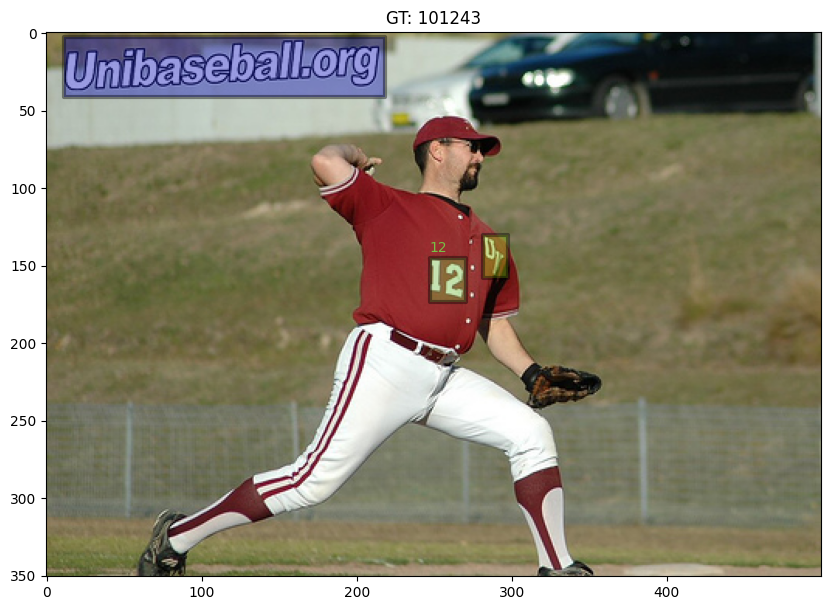

In [48]:
img_id = 101243
img_meta = ct.loadImgs(ids=[img_id])[0]
plt.imshow(plt.imread(images_path / img_meta['file_name']))
annIds = ct.getAnnIds(imgIds=img_meta['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title(f"GT: {img_meta['id']}")


In [49]:
img, anno = ds_val[ds_val.ids.index(str(img_id))]

In [50]:
preds = model([img])[0]

In [51]:
import torchvision

Text(0.5, 1.0, 'Pred: все боксы')

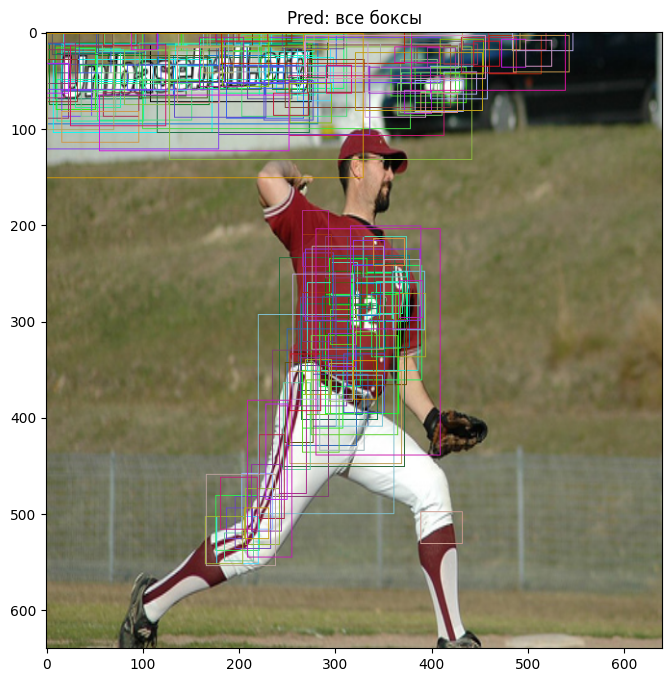

In [52]:
plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        (img * 255 ).type(torch.uint8), 
        preds['boxes'],
    ).permute(1, 2, 0),
)
plt.title("Pred: все боксы")

Text(0.5, 1.0, 'Pred: боксы с score > 0.35')

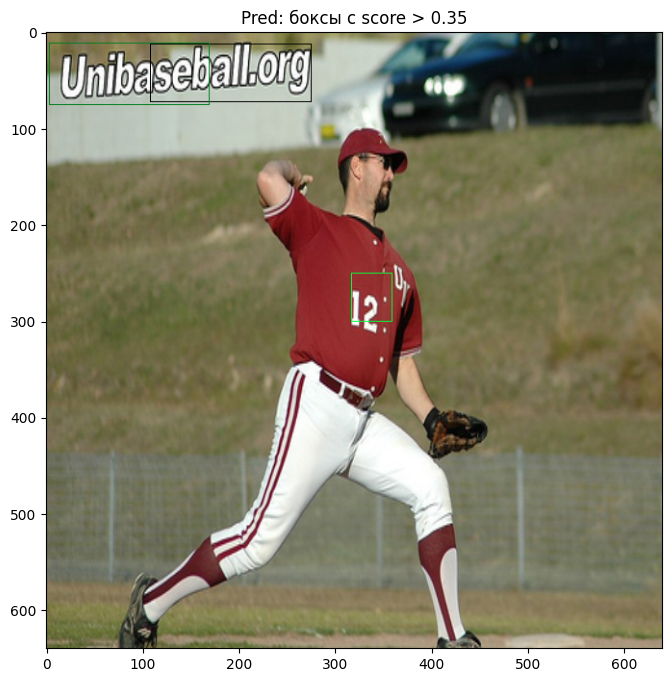

In [56]:
high_confidence_scores = preds['scores'] > 0.35
high_confidence_boxes = preds['boxes'][high_confidence_scores]
plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        (img * 255 ).type(torch.uint8), 
        high_confidence_boxes
    ).permute(1, 2, 0),
)
plt.title("Pred: боксы с score > 0.35")

Стандартные детекторы плохо справляются с детектированием боксов aspect_ratio >> 1, поэтому есть много специализированных моделей для детекции текста.

HINT: в retina по умолчанию отключен NMS, но его можно включить

### Подготовка файла предсказаний

In [57]:
def postprocess(preds, size_src=None, size_current=None):
    """
    Перевод предсказаний Retina в формате [xmin, ymin, xmax, ymax], 
    в формат COCO [xmin, ymin, wx, hy]
    Масштабирование боксов согласно оригинальному размеру изображения.
    """
    unfold_results = {}
    unf = {"scores": preds["scores"].cpu().detach().numpy()}
    b = preds["boxes"].clone().detach()
    boxes = b.clone()
        
    boxes[:, 2] = (b[:, 2] - b[:, 0])
    boxes[:, 3] = (b[:, 3] - b[:, 1])
    if size_src is not None and size_current is not None:
        mult_0 = size_src[0] / size_current[0]
        mult_1 = size_src[1] / size_current[1]

        boxes[:, 0] *= mult_0
        boxes[:, 2] *= mult_0
        boxes[:, 1] *= mult_1
        boxes[:, 3] *= mult_1
    unf['boxes'] = boxes.numpy()
        
    return unf

### Посчитаем предсказания на val датасете

In [58]:
model = model.cuda();

In [59]:
prepared_preds = []
img_ids = []

for num, img_id in enumerate(tqdm(ds_val.ids)):
    img_id = int(img_id)
    img_meta = ct.loadImgs(ids=[img_id])[0]
    with torch.no_grad():
        x = ds_val[num][0]
        pred = model([
            x.cuda()
        ])[0]
        pred = dict((k, v.cpu()) for (k,v) in pred.items())
        prepared_preds.append(
            postprocess(
                pred,
                size_src=[img_meta['width'], img_meta['height']], 
                size_current=[640, 640]
            )
        )
        img_ids.append(img_id)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4446/4446 [02:48<00:00, 26.41it/s]


### Эта функция соранит детекции в нужном формате

In [60]:
from a4_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [61]:
scores = np.concatenate([u['scores'] for u in prepared_preds])
boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)

In [62]:
image_ids = []
for num, i in enumerate(img_ids):
    image_ids += [i] * len(prepared_preds[num]['boxes'])
image_ids = np.array(image_ids)

In [63]:
dump_detections_to_cocotext_json(
    image_ids = image_ids.tolist(),
    xlefts=boxes[:, 0].tolist(),
    ytops=boxes[:, 1].tolist(),
    widths=boxes[:, 2].tolist(),
    heights=boxes[:, 3].tolist(),
    scores=scores.tolist(),
    path='predictions.json'
);
    

### Эта функция посчитает AP детекций
AP считается согласно PASCAL-VOC - площадь под Precision-Recall кривой.

Дополнительно из Ground Truth выбрасываются объекты с площадью меньше 1/32/32, т.к. для уверенного детектирования таких объектов придется тренировать детектора в большом разрешении.
По умолчанию во время тренировки CocoTextDetection также выбрасывает такие боксы, определяется параметром area_fraction_threshold.

In [64]:
from a4_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json

In [65]:
ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path='predictions.json'
)
print(f"Итоговый скор AP на val: {ap}")

Loading and preparing results...     
DONE (t=26.80s)
Итоговый скор AP на val: 0.0879410159845993


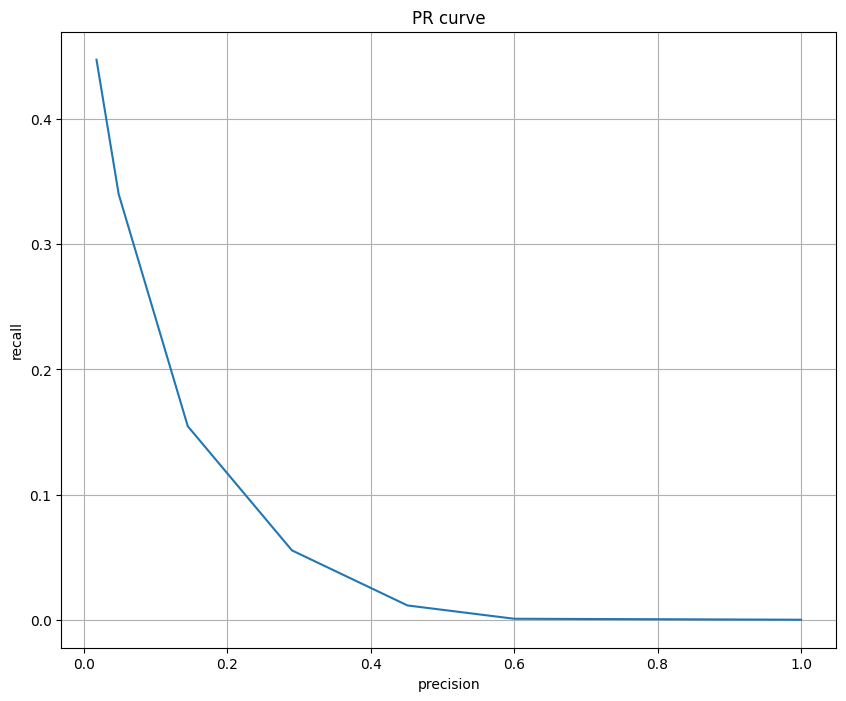

In [66]:
from matplotlib import pyplot as plt
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()